In [1]:
# Importazione delle librerie necessarie
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
# Caricamento dei dati
data = pd.read_csv('data.csv')

data = data.astype({'SampleTime': 'float64', 'SensorID': 'float64', 'Value': 'float64'})

# Visualizzazione delle prime righe per confermare il caricamento
print(data.head(5))

   SampleTime  SensorID     Value
0         0.0       2.0  0.033883
1         0.0       4.0 -0.009496
2         0.0       5.0  0.000000
3         0.0       7.0 -0.057306
4         0.0       8.0  0.029096


In [3]:
# Organizza i dati in una matrice di sensori (timestamp x sensori)
pivot_data = data.pivot(index='SampleTime', columns='SensorID', values='Value').fillna(0)

# Converti il dataframe in una matrice numpy
X = pivot_data.to_numpy()

# Calcola la media e la matrice di covarianza
mu_X = np.mean(X, axis=0)
cov_X = np.cov(X, rowvar=False)

In [4]:
def optimize_sensors(X, B):
    n = X.shape[1]

    # Funzione obiettivo per minimizzare la varianza
    def objective_var(alpha):
        Y = X @ alpha
        return np.var(Y)
    
    # Funzione obiettivo per massimizzare il valore atteso
    def objective_mean(alpha):
        Y = X @ alpha
        return -np.mean(Y)

    # Vincoli
    def constraint_sum_alpha(alpha):
        return np.sum(alpha) - 1
    
    constraints = [{'type': 'eq', 'fun': constraint_sum_alpha}]
    bounds = [(0, 1) for _ in range(n)]
    
    # Minimizzazione della varianza
    alpha_init = np.ones(n) / n
    result_var = minimize(objective_var, alpha_init, constraints=constraints, bounds=bounds)
    best_var = result_var.fun
    best_alpha_var = result_var.x

    # Seleziona i B coefficienti più grandi
    indices = np.argsort(best_alpha_var)[-B:]
    alpha_restricted = np.zeros(n)
    alpha_restricted[indices] = 1 / B

    # Massimizzazione del valore atteso con vincolo sulla varianza
    def constraint_var(alpha):
        return best_var - objective_var(alpha)
    
    constraints.append({'type': 'ineq', 'fun': constraint_var})

    result_mean = minimize(objective_mean, alpha_restricted, constraints=constraints, bounds=bounds)
    best_alpha_mean = result_mean.x

    # Imposta a zero tutti i coefficienti tranne i B selezionati
    best_alpha_mean[best_alpha_mean < np.sort(best_alpha_mean)[-B]] = 0

    return best_alpha_mean

In [5]:
# Esegui l'ottimizzazione con B = 10
B = 10
optimal_alpha = optimize_sensors(X, B)
print("Optimal alpha:", optimal_alpha)
a = sum(optimal_alpha)
a

Optimal alpha: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.05421013
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.05164333

0.470194763123853

In [6]:
# Costruisci il sensore virtuale
Y = X @ optimal_alpha

# Converti il sensore virtuale in un dataframe per analisi
sensor_virtuale = pd.DataFrame({'SampleTime': pivot_data.index, 'VirtualSensor': Y})

print(sensor_virtuale.head())

   SampleTime  VirtualSensor
0         0.0       0.000579
1         1.0      -0.001149
2         2.0       0.001782
3         3.0       0.000561
4         4.0      -0.000184


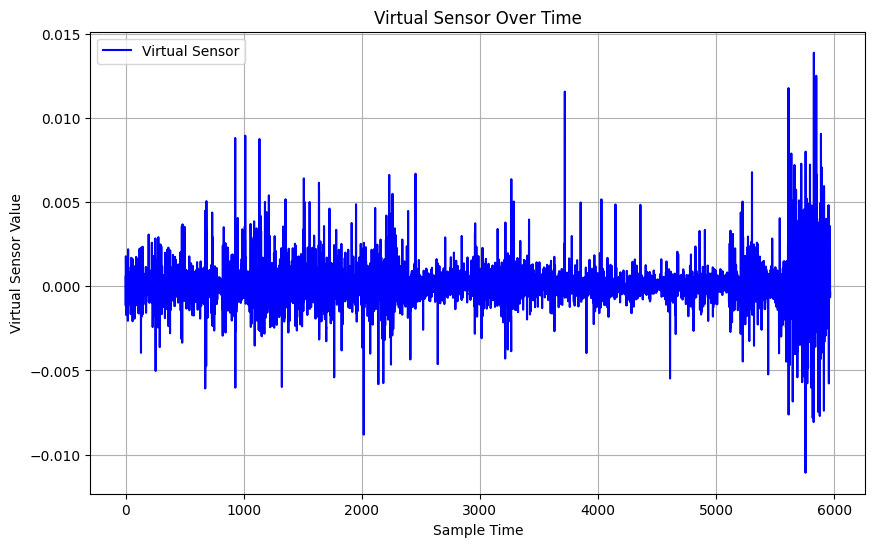

In [7]:
# Plot del sensore virtuale
plt.figure(figsize=(10, 6))
plt.plot(sensor_virtuale['SampleTime'], sensor_virtuale['VirtualSensor'], label='Virtual Sensor', color='b')
plt.xlabel('Sample Time')
plt.ylabel('Virtual Sensor Value')
plt.title('Virtual Sensor Over Time')
plt.legend()
plt.grid(True)
plt.show()

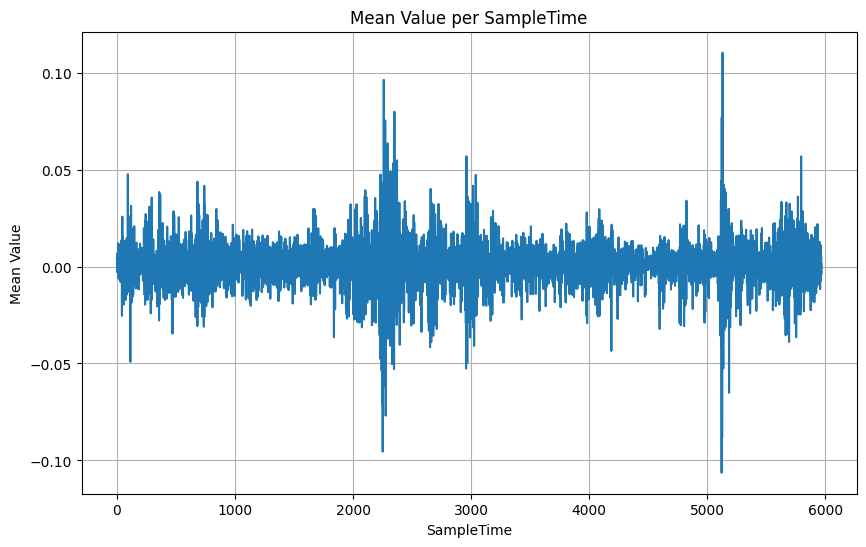

In [8]:
# Calcola la media dei valori per ogni SampleTime
mean_values = data.groupby('SampleTime')['Value'].mean()

# Plot della media dei valori per SampleTime
plt.figure(figsize=(10, 6))
plt.plot(mean_values.index, mean_values.values)
plt.xlabel('SampleTime')
plt.ylabel('Mean Value')
plt.title('Mean Value per SampleTime')
plt.grid(True)
plt.show()